In [1]:
import windio2cad.geometry_tools

In [48]:
from typing import Dict, List, Any, Optional
import argparse
import yaml
import numpy as np
from scipy.interpolate import PchipInterpolator as spline
import windio2cad.geometry_tools as geom
import solid
import subprocess
from numpy.linalg import norm
from math import sin, cos
import matplotlib.pyplot as plt


class Blade:
    """
    This class renders one blade for the rotor.
    """

    def __init__(self, yaml_filename: str):
        """
        The constructor opens the YAML file and extracts the blade
        and airfoil information into instance attributes.

        Parameters
        ----------
        yaml_filename: str
            Filename that contains the geometry for the rotor.
        """
        geometry = yaml.load(open(yaml_filename, "r"), yaml.FullLoader)
        self.outer_shape = geometry["components"]["blade"]["outer_shape_bem"]
        self.airfoils = geometry["airfoils"]

    @staticmethod
    def myinterp(xi, x, f) -> np.array:
        myspline = spline(x, f)
        return myspline(xi)

    def generate_lofted(self, n_span_min=10, n_xy=8) -> np.array:
        """
        Creates the lofted shape of a blade and returns a NumPy array
        of the polygons at each cross section.

        Parameters
        ----------
        n_span_min: int
            Number of cross sections to create across span of
            blade.

        n_xy: int
            The number of x, y points in the polygons at each slice of
            the blade.

        Returns
        -------
        np.array
            An array of the polygons at each cross section of the blade.
        """
        # Use yaml grid points and others that we add
        r_span = np.unique(
            np.r_[
                np.linspace(0.0, 1.0, n_span_min),
                self.outer_shape["chord"]["grid"],
                self.outer_shape["twist"]["grid"],
                self.outer_shape["pitch_axis"]["grid"],
                self.outer_shape["reference_axis"]["x"]["grid"],
                self.outer_shape["reference_axis"]["y"]["grid"],
                self.outer_shape["reference_axis"]["z"]["grid"],
            ]
        )
        n_span = len(r_span)
        

        # Read in blade spanwise geometry values and put on common grid
        chord = self.myinterp(
            r_span,
            self.outer_shape["chord"]["grid"],
            self.outer_shape["chord"]["values"],
        )
        twist = self.myinterp(
            r_span,
            self.outer_shape["twist"]["grid"],
            self.outer_shape["twist"]["values"],
        )
        pitch_axis = self.myinterp(
            r_span,
            self.outer_shape["pitch_axis"]["grid"],
            self.outer_shape["pitch_axis"]["values"],
        )
        ref_axis = np.c_[
            self.myinterp(
                r_span,
                self.outer_shape["reference_axis"]["x"]["grid"],
                self.outer_shape["reference_axis"]["x"]["values"],
            ),
            self.myinterp(
                r_span,
                self.outer_shape["reference_axis"]["y"]["grid"],
                self.outer_shape["reference_axis"]["y"]["values"],
            ),
            self.myinterp(
                r_span,
                self.outer_shape["reference_axis"]["z"]["grid"],
                self.outer_shape["reference_axis"]["z"]["values"],
            ),
        ]

        # Get airfoil names and thicknesses
        af_position = self.outer_shape["airfoil_position"]["grid"]
        af_used = self.outer_shape["airfoil_position"]["labels"]
        n_af_span = len(af_position)
        n_af = len(self.airfoils)
        name = n_af * [""]
        r_thick = np.zeros(n_af)
        for i in range(n_af):
            name[i] = self.airfoils[i]["name"]
            r_thick[i] = self.airfoils[i]["relative_thickness"]

        fig, ax1 = plt.subplots()

        # Create common airfoil coordinates grid
        coord_xy = np.zeros((n_af, n_xy, 2))
        for i in range(n_af):
            points = np.c_[
                self.airfoils[i]["coordinates"]["x"],
                self.airfoils[i]["coordinates"]["y"],
            ]

            # Check that airfoil points are declared from the TE suction side to TE pressure side
            idx_le = np.argmin(points[:, 0])
            if np.mean(points[:idx_le, 1]) > 0.0:
                points = np.flip(points, axis=0)

            # ax1.plot(points[:,0], points[:, 1])
            # ax1.set_xlabel('x')
            # ax1.set_ylabel('y')
            
            # Remap points using class AirfoilShape
            af = geom.AirfoilShape(points=points)
            af.redistribute(n_xy, even=False, dLE=True)
            af_points = af.points

            # Add trailing edge point if not defined
            if [1, 0] not in af_points.tolist():
                af_points[:, 0] -= af_points[np.argmin(af_points[:, 0]), 0]
            c = max(af_points[:, 0]) - min(af_points[:, 0])
            af_points[:, :] /= c

            coord_xy[i, :, :] = af_points

            # ax1.plot(coord_xy[i,:,0], coord_xy[i, :,1])
            # ax1.set_xlabel('x')
            # ax1.set_ylabel('y')

        # Reconstruct the blade relative thickness along span with a pchip
        r_thick_used = np.zeros(n_af_span)
        coord_xy_used = np.zeros((n_af_span, n_xy, 2))
        coord_xy_interp = np.zeros((n_span, n_xy, 2))
        coord_xy_dim = np.zeros((n_span, n_xy, 2))

        for i in range(n_af_span):
            for j in range(n_af):
                if af_used[i] == name[j]:
                    r_thick_used[i] = r_thick[j] * 3
                    coord_xy_used[i, :, :] = coord_xy[j, :, :]
        
            # ax1.plot(coord_xy_used[i,:,0], coord_xy_used[i, :,1])
            # ax1.set_xlabel('x')
            # ax1.set_ylabel('y')

        r_thick_interp = self.myinterp(r_span, af_position, r_thick_used)

        # Spanwise interpolation of the profile coordinates with a pchip
        r_thick_unique, indices = np.unique(r_thick_used, return_index=True)
        coord_xy_interp = np.flip(
            self.myinterp(
                np.flip(r_thick_interp), r_thick_unique, coord_xy_used[indices, :, :]
            ),
            axis=0,
        )
        for i in range(n_span):
            # ax1.plot(coord_xy_interp[i,:,0], coord_xy_interp[i, :,1])
            # ax1.set_xlabel('x')
            # ax1.set_ylabel('y')
            # Correction to move the leading edge (min x point) to (0,0)
            af_le = coord_xy_interp[i, np.argmin(coord_xy_interp[i, :, 0]), :]
            coord_xy_interp[i, :, 0] -= af_le[0]
            coord_xy_interp[i, :, 1] -= af_le[1]
            c = max(coord_xy_interp[i, :, 0]) - min(coord_xy_interp[i, :, 0])
            coord_xy_interp[i, :, :] /= c
            # If the rel thickness is smaller than 0.4 apply a trailing ege smoothing step
            # if r_thick_interp[i] < 0.4:
                # coord_xy_interp[i, :, :] = geom.trailing_edge_smoothing(
                    # coord_xy_interp[i, :, :]
                # )
            
            # ax1.plot(coord_xy_interp[i,:,0], coord_xy_interp[i, :,1])
            # ax1.set_xlabel('x')
            # ax1.set_ylabel('y')

        # Offset by pitch axis and scale for chord
        coord_xy_dim = coord_xy_interp.copy()
        coord_xy_dim[:, :, 0] -= pitch_axis[:, np.newaxis]
        coord_xy_dim = coord_xy_dim * chord[:, np.newaxis, np.newaxis]

        # Rotate to twist angle
        coord_xy_dim_twisted = np.zeros(coord_xy_interp.shape)
        for i in range(n_span):
            # ax1.plot(coord_xy_dim[i,:,0], coord_xy_dim[i, :,1])
            # ax1.set_xlabel('x')
            # ax1.set_ylabel('y')
            x = coord_xy_dim[i, :, 0]
            y = coord_xy_dim[i, :, 1]
            coord_xy_dim_twisted[i, :, 0] = x * np.cos(twist[i]) - y * np.sin(twist[i])
            coord_xy_dim_twisted[i, :, 1] = y * np.cos(twist[i]) + x * np.sin(twist[i])

            # ax1.plot(coord_xy_dim_twisted[i,:,0], coord_xy_dim_twisted[i, :,1])
            # ax1.set_xlabel('x')
            # ax1.set_ylabel('y')

        # Assemble lofted shape along reference axis
        lofted_shape = np.zeros((n_span, n_xy, 3))
        for i in range(n_span):
            for j in range(n_xy):
                lofted_shape[i, j, :] = (
                    np.r_[
                        coord_xy_dim_twisted[i, j, 1],
                        coord_xy_dim_twisted[i, j, 0],
                        0.0,
                    ]
                    + ref_axis[i, :]
                )
            ax1.plot(lofted_shape[i,:,0], lofted_shape[i, :,1])
            ax1.set_xlabel('x')
            ax1.set_ylabel('y')

        return lofted_shape

    def blade_hull(self, downsample_z: int = 1) -> solid.OpenSCADObject:
        """
        This creates an OpenSCAD hull object around cross sections of a blade,
        thereby rendering the complete geometry for a single blade.

        Parameters
        ----------
        downsample_z: int
            Skips to every nth sample across the z axis of the blade. For
            example, 10 uses only every tenth cross section.

        Returns
        -------
        solid.OpenSCADObject
            The OpenSCAD object that is ready to render to code.
        """

        # Get the lofted shape and the number of sections across its span
        lofted_shape = self.generate_lofted()
        n_span = lofted_shape.shape[0]

        # Find the distance between each cross section. Find the minimum of
        # these distances and multiply by 0.1. This will be the height of each
        # extrusion for each cross section.

        diff_z = []
        for k in range(n_span - 1):
            diff_z.append(lofted_shape[k + 1, 0, 2] - lofted_shape[k, 0, 2])
        dz = 0.1 * min(diff_z)

        # Make the range to sample the span of the blade. If downsample_z
        # is 1, that means every cross section will be plotted. If it is
        # greater than 1, samples will be skipped. This is reflected in
        # the range to sample the span.

        if downsample_z == 1:
            n_span_range = range(n_span)
        else:
            n_span_range = range(0, n_span, downsample_z)

        # Create one extrusion per cross section.
        extrusions = []
        for k in n_span_range:
            bottom = lofted_shape[k, 0, 2]
            points = tuple((row[0], row[1]) for row in lofted_shape[k, :, :])
            polygon = solid.polygon(points)
            extrusion = solid.linear_extrude(dz)(polygon)
            translated_extrusion = solid.translate((0.0, 0.0, bottom))(extrusion)
            extrusions.append(translated_extrusion)

        # Create a hull around all the cross sections and return it.
        hull_of_extrusions = solid.hull()(extrusions)
        return hull_of_extrusions

10
(158, 200, 3)


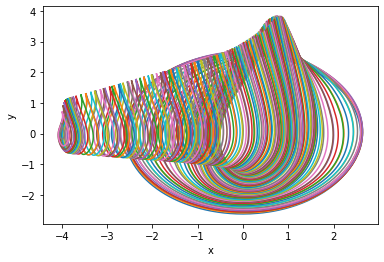

In [55]:
blade = Blade('IEA-15-240-RWT.yaml')
print(len(blade.outer_shape['airfoil_position']['labels']))
points = blade.generate_lofted(n_span_min=100, n_xy=200)
# points = blade.blade_hull(downsample_z = 10)

print(points.shape)


f = open('surf_coarse.plt','w')

f.write('TITLE = \" WINDIO TEST CASE\" \n')
f.write('VARIABLES = \"X\" \"Y\" \"Z\" \n')
f.write('ZONE I= {} J = {} F=point \n'.format(points.shape[1] + 1, int(points.shape[0]/6)))
for i in range(points.shape[0]):
    if i % 6 == 0 :
        for j in range(points.shape[1]):
            f.write('{} \t {} \t {}\n'.format(points[i, j, 0], points[i, j, 1], points[i, j, 2]))
        f.write('{} \t {} \t {}\n'.format(points[i, 0, 0], points[i, 0, 1], points[i, 0, 2]))

f.close()

f = open('../FLOWSOLVER2018/IEA_15MW/IEA_15MW_patch_coarse.dat','w')
f.write('{} \t {} \n'.format(points.shape[1] + 1, points.shape[0]))
for i in range(points.shape[0]):
    for j in range(points.shape[1]):
        f.write('{} \t {} \t {}\n'.format(points[i, j, 1] * 5, points[i, j, 2] + 3, points[i, j, 0] * 5))
    f.write('{} \t {} \t {}\n'.format(points[i, 0, 1] * 5, points[i, 0, 2] + 3, points[i, 0, 0] * 5))

f.close()

f = open('surf_coarse.p3d','w')

npts = points.shape[0] * points.shape[1]

f.write('{} \t {} \t {} \n'.format(points.shape[1] + 1, points.shape[0], 1))
for i in range(points.shape[0]):
    for j in range(points.shape[1]):
        f.write('{}\n'.format(points[i, j, 0]))
    f.write('{}\n'.format(points[i, 0, 0]))
for i in range(points.shape[0]):
    for j in range(points.shape[1]):
        f.write('{}\n'.format(points[i, j, 1]))
    f.write('{}\n'.format(points[i, 0, 1]))
for i in range(points.shape[0]):
    for j in range(points.shape[1]):
        f.write('{}\n'.format(points[i, j, 2]))
    f.write('{}\n'.format(points[i, 0, 2]))



f.close()




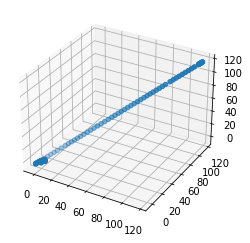

In [4]:
import matplotlib.pyplot as plt 

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(points[:,0], points[:,1], points[:,2])



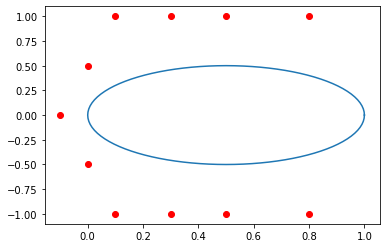

In [5]:
import matplotlib.pyplot as plt
import numpy as np

naca0012 = np.loadtxt('n0012.dat', skiprows=3)

circ_x = [1.00000, 0.99901, 0.99606, 0.99114, 0.98429, 0.97553, 0.96489, 0.95241, 0.93815, 0.92216, 0.90451, 0.88526, 0.86448, 0.84227, 0.81871, 0.79389, 0.76791, 0.74088, 0.71289, 0.68406, 0.65451, 0.62434, 0.59369, 0.56267, 0.53140, 0.50000, 0.46860, 0.43733, 0.40631, 0.37566, 0.34549, 0.31594, 0.28711, 0.25912, 0.23209, 0.20611, 0.18129, 0.15773, 0.13552, 0.11474, 0.09549, 0.07784, 0.06185, 0.04759, 0.03511, 0.02447, 0.01571, 0.00886, 0.00394, 0.00099, 0.00000, 0.00099, 0.00394, 0.00886, 0.01571, 0.02447, 0.03511, 0.04759, 0.06185, 0.07784, 0.09549, 0.11474, 0.13552, 0.15773, 0.18129, 0.20611, 0.23209, 0.25912, 0.28711, 0.31594, 0.34549, 0.37566, 0.40631, 0.43733, 0.46860, 0.50000, 0.53140, 0.56267, 0.59369, 0.62434, 0.65451, 0.68406, 0.71289, 0.74088, 0.76791, 0.79389, 0.81871, 0.84227, 0.86448, 0.88526, 0.90451, 0.92216, 0.93815, 0.95241, 0.96489, 0.97553, 0.98429, 0.99114, 0.99606, 0.99901, 1.00000]
circ_y = [0.00000, 0.03140, 0.06267, 0.09369, 0.12434, 0.15451, 0.18406, 0.21289, 0.24088, 0.26791, 0.29389, 0.31871, 0.34227, 0.36448, 0.38526, 0.40451, 0.42216, 0.43815, 0.45241, 0.46489, 0.47553, 0.48429, 0.49114, 0.49606, 0.49901, 0.50000, 0.49901, 0.49606, 0.49114, 0.48429, 0.47553, 0.46489, 0.45241, 0.43815, 0.42216, 0.40451, 0.38526, 0.36448, 0.34227, 0.31871, 0.29389, 0.26791, 0.24088, 0.21289, 0.18406, 0.15451, 0.12434, 0.09369, 0.06267, 0.03140, 0.00000, -0.03140, -0.06267, -0.09369, -0.12434, -0.15451, -0.18406, -0.21289, -0.24088, -0.26791, -0.29389, -0.31871, -0.34227, -0.36448, -0.38526, -0.40451, -0.42216, -0.43815, -0.45241, -0.46489, -0.47553, -0.48429, -0.49114, -0.49606, -0.49901, -0.50000, -0.49901, -0.49606, -0.49114, -0.48429, -0.47553, -0.46489, -0.45241, -0.43815, -0.42216, -0.40451, -0.38526, -0.36448, -0.34227, -0.31871, -0.29389, -0.26791, -0.24088, -0.21289, -0.18406, -0.15451, -0.12434, -0.09369, -0.06267, -0.03140, 0.00000]

fig, ax1 = plt.subplots()
# ax1.plot(naca0012[:, 0], naca0012[:,1])
ax1.plot(circ_x, circ_y)

control_cage_x = np.array([0.8, 0.5, 0.3, 0.1, 0, -0.1, 0, 0.1, 0.3, 0.5, 0.8])
control_cage_y = np.array([1, 1, 1, 1, 0.5, 0, -0.5, -1, -1, -1, -1])

# control_cage_y = control_cage_y * 10

ax1.plot(control_cage_x, control_cage_y, 'ro')

circular
circular
SNL-FFA-W3-500
FFA-W3-360
FFA-W3-330blend
FFA-W3-301
FFA-W3-270blend
FFA-W3-241
FFA-W3-211
FFA-W3-211


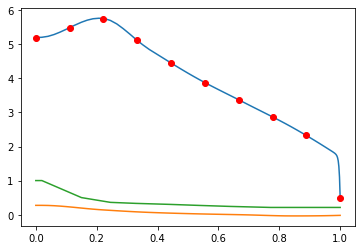

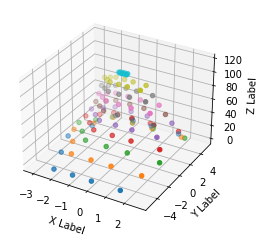

In [54]:
blade = Blade('IEA-15-240-RWT.yaml')

# Get surface distribution data

chord_d = blade.outer_shape['chord']
twist_d = blade.outer_shape['twist']
pitch_axis_d = blade.outer_shape['pitch_axis']
x_d = blade.outer_shape['reference_axis']['x']
y_d = blade.outer_shape['reference_axis']['y']
z_d = blade.outer_shape['reference_axis']['z']

thick_d = {'grid' : [], 'values' : []}


for section in blade.outer_shape['airfoil_position']['labels']:
    print(section)
    thick_d['values'].append(next(item for item in blade.airfoils if item["name"] == section)['relative_thickness'])

for grid in blade.outer_shape['airfoil_position']['grid']:
    thick_d['grid'].append(grid)

plt.plot(chord_d['grid'], chord_d['values'])
plt.plot(twist_d['grid'], twist_d['values'])
plt.plot(thick_d['grid'], thick_d['values'])

# interpolate datasets
n_stations = 10

locations = np.linspace(0, 1, n_stations)


chord_i = np.interp(locations, chord_d['grid'], chord_d['values'])
twist_i = np.interp(locations, twist_d['grid'], twist_d['values'])
thick_i = np.interp(locations, thick_d['grid'], thick_d['values'])
pitch_axis_i = np.interp(locations, pitch_axis_d['grid'], pitch_axis_d['values'])
x_i = np.interp(locations, x_d['grid'], x_d['values'])
y_i = np.interp(locations, y_d['grid'], y_d['values'])
z_i = np.interp(locations, z_d['grid'], z_d['values'])

plt.plot(locations, chord_i, 'ro')

# Prepare control cage

x = np.array([0.8, 0.5, 0.3, 0.1, 0, -0.1, 0, 0.1, 0.3, 0.5, 0.8])
y = np.array([1, 1, 1, 1, 0.5, 0, -0.5, -1, -1, -1, -1])

# control_cage_x = np.array([1, 1, 1, 1, 0.5, 0, -0.5, -1, -1, -1, -1]) * 0.5
# control_cage_y = (np.array([0.8, 0.5, 0.3, 0.1, 0, -0.1, 0, 0.1, 0.3, 0.5, 0.8]) -0.4) * 2

# control_cage_x = np.array([0])
# control_cage_y = np.array([0])

# x= np.array([1.00000000, 0.99944304, 0.99812049, 0.99569352, 0.99230484, 0.98802844, 0.98281508, 0.97666422, 0.96964069, 0.96174313, 0.95297315, 0.94338928, 0.93301284, 0.92185147, 0.90995468, 0.89736121, 0.88408503, 0.87016290, 0.85565276, 0.84057695, 0.82497463, 0.80889455, 0.79236237, 0.77542101, 0.75812546, 0.74050180, 0.72259209, 0.70444539, 0.68608843, 0.66757021, 0.64892678, 0.63018643, 0.61140138, 0.59259673, 0.57380843, 0.55507570, 0.53641763, 0.51787958, 0.49948103, 0.48125155, 0.46322225, 0.44540666, 0.42784323, 0.41053864, 0.39352525, 0.37681123, 0.36041977, 0.34436494, 0.32865846, 0.31331898, 0.29834798, 0.28376580, 0.26956679, 0.25577362, 0.24237780, 0.22939648, 0.21681735, 0.20465763, 0.19290757, 0.18157496, 0.17065819, 0.16014896, 0.15005511, 0.14035465, 0.13106750, 0.12216148, 0.11365876, 0.10553619, 0.09779065, 0.09042902, 0.08341621, 0.07677403, 0.07046920, 0.06450016, 0.05888182, 0.05356799, 0.04857581, 0.04389793, 0.03949498, 0.03539484, 0.03157626, 0.02800644, 0.02471592, 0.02168071, 0.01886319, 0.01629514, 0.01396620, 0.01181764, 0.00988361, 0.00818368, 0.00663128, 0.00524853, 0.00408271, 0.00308998, 0.00219098, 0.00145967, 0.00096333, 0.00059878, 0.00028988, 0.00007804, 0.00000000, 0.00007807, 0.00029009, 0.00059937, 0.00096448, 0.00146264, 0.00219661, 0.00309879, 0.00409516, 0.00526774, 0.00665839, 0.00821941, 0.00993095, 0.01187982, 0.01404463, 0.01639219, 0.01898469, 0.02182867, 0.02489252, 0.02822001, 0.03182924, 0.03568998, 0.03984236, 0.04430035, 0.04903788, 0.05410025, 0.05948747, 0.06518787, 0.07124791, 0.07764648, 0.08439704, 0.09152340, 0.09900711, 0.10688721, 0.11514762, 0.12380644, 0.13287211, 0.14233176, 0.15221460, 0.16249918, 0.17321393, 0.18434125, 0.19590296, 0.20788328, 0.22029378, 0.23312344, 0.24637487, 0.26004146, 0.27412439, 0.28861129, 0.30349962, 0.31877410, 0.33443448, 0.35045732, 0.36684322, 0.38356093, 0.40060975, 0.41795607, 0.43559330, 0.45349250, 0.47163211, 0.48999236, 0.50853595, 0.52724867, 0.54608860, 0.56503090, 0.58404504, 0.60308800, 0.62213765, 0.64114752, 0.66008031, 0.67890619, 0.69757164, 0.71604492, 0.73429135, 0.75225234, 0.76989792, 0.78719153, 0.80407383, 0.82051349, 0.83646946, 0.85189026, 0.86674791, 0.88100970, 0.89461041, 0.90752456, 0.91973040, 0.93117530, 0.94182765, 0.95167536, 0.96067486, 0.96878747, 0.97601191, 0.98233053, 0.98768615, 0.99208631, 0.99557391, 0.99806302, 0.99942968, 1.00000000])
# y = np.array([0.00425000, 0.00436210, 0.00462832, 0.00511699, 0.00579959, 0.00666146, 0.00771282, 0.00895410, 0.01037253, 0.01196864, 0.01374233, 0.01568187, 0.01778563, 0.02006929, 0.02251710, 0.02513781, 0.02790923, 0.03084911, 0.03393611, 0.03716418, 0.04052857, 0.04400982, 0.04761716, 0.05132667, 0.05512297, 0.05899393, 0.06293412, 0.06690084, 0.07088321, 0.07486708, 0.07883497, 0.08275436, 0.08661408, 0.09037299, 0.09402539, 0.09754917, 0.10092636, 0.10414685, 0.10719326, 0.11006231, 0.11271220, 0.11514729, 0.11735341, 0.11931701, 0.12102638, 0.12248809, 0.12367942, 0.12460233, 0.12523852, 0.12560509, 0.12567380, 0.12546547, 0.12498975, 0.12423636, 0.12323884, 0.12200236, 0.12053786, 0.11886654, 0.11699332, 0.11492977, 0.11269298, 0.11029800, 0.10776785, 0.10510781, 0.10233142, 0.09945032, 0.09649044, 0.09345853, 0.09036359, 0.08722175, 0.08403450, 0.08082678, 0.07759443, 0.07434789, 0.07110954, 0.06787343, 0.06465344, 0.06145399, 0.05826012, 0.05510950, 0.05199557, 0.04891845, 0.04589051, 0.04289625, 0.03991914, 0.03700233, 0.03418463, 0.03137187, 0.02861090, 0.02603794, 0.02342947, 0.02076107, 0.01830451, 0.01595100, 0.01327076, 0.01049860, 0.00746215, 0.00453721, 0.00204453, 0.00050657, 0.00000000, -0.00049018, -0.00184125, -0.00381822, -0.00605713, -0.00870563, -0.01122916, -0.01342212, -0.01534366, -0.01716693, -0.01909642, -0.02130654, -0.02351414, -0.02579914, -0.02815987, -0.03053974, -0.03296857, -0.03549058, -0.03807470, -0.04072568, -0.04345995, -0.04623151, -0.04907034, -0.05196961, -0.05490886, -0.05790431, -0.06095001, -0.06402491, -0.06712837, -0.07024411, -0.07337047, -0.07649115, -0.07959568, -0.08268285, -0.08571902, -0.08870503, -0.09161742, -0.09443777, -0.09716583, -0.09976981, -0.10223862, -0.10454454, -0.10668939, -0.10863043, -0.11037325, -0.11187776, -0.11314131, -0.11414886, -0.11486604, -0.11529721, -0.11537968, -0.11513331, -0.11450572, -0.11349774, -0.11208121, -0.11023393, -0.10793345, -0.10519348, -0.10197553, -0.09829760, -0.09414081, -0.08952202, -0.08447312, -0.07905685, -0.07331017, -0.06729960, -0.06109331, -0.05477058, -0.04842523, -0.04213791, -0.03600811, -0.03012656, -0.02457508, -0.01942136, -0.01470107, -0.01045419, -0.00673447, -0.00355842, -0.00093374, 0.00117919, 0.00284598, 0.00409407, 0.00495249, 0.00546535, 0.00561958, 0.00547727, 0.00504714, 0.00440395, 0.00360867, 0.00270812, 0.00180270, 0.00091285, 0.00005718, -0.00074311, -0.00146131, -0.00207989, -0.00258907, -0.00296293, -0.00317197, -0.00326000])

# x = np.array([1.00000, 0.99901, 0.99606, 0.99114, 0.98429, 0.97553, 0.96489, 0.95241, 0.93815, 0.92216, 0.90451, 0.88526, 0.86448, 0.84227, 0.81871, 0.79389, 0.76791, 0.74088, 0.71289, 0.68406, 0.65451, 0.62434, 0.59369, 0.56267, 0.53140, 0.50000, 0.46860, 0.43733, 0.40631, 0.37566, 0.34549, 0.31594, 0.28711, 0.25912, 0.23209, 0.20611, 0.18129, 0.15773, 0.13552, 0.11474, 0.09549, 0.07784, 0.06185, 0.04759, 0.03511, 0.02447, 0.01571, 0.00886, 0.00394, 0.00099, 0.00000, 0.00099, 0.00394, 0.00886, 0.01571, 0.02447, 0.03511, 0.04759, 0.06185, 0.07784, 0.09549, 0.11474, 0.13552, 0.15773, 0.18129, 0.20611, 0.23209, 0.25912, 0.28711, 0.31594, 0.34549, 0.37566, 0.40631, 0.43733, 0.46860, 0.50000, 0.53140, 0.56267, 0.59369, 0.62434, 0.65451, 0.68406, 0.71289, 0.74088, 0.76791, 0.79389, 0.81871, 0.84227, 0.86448, 0.88526, 0.90451, 0.92216, 0.93815, 0.95241, 0.96489, 0.97553, 0.98429, 0.99114, 0.99606, 0.99901, 1.00000])
# y = np.array([0.00000, 0.03140, 0.06267, 0.09369, 0.12434, 0.15451, 0.18406, 0.21289, 0.24088, 0.26791, 0.29389, 0.31871, 0.34227, 0.36448, 0.38526, 0.40451, 0.42216, 0.43815, 0.45241, 0.46489, 0.47553, 0.48429, 0.49114, 0.49606, 0.49901, 0.50000, 0.49901, 0.49606, 0.49114, 0.48429, 0.47553, 0.46489, 0.45241, 0.43815, 0.42216, 0.40451, 0.38526, 0.36448, 0.34227, 0.31871, 0.29389, 0.26791, 0.24088, 0.21289, 0.18406, 0.15451, 0.12434, 0.09369, 0.06267, 0.03140, 0.00000, -0.03140, -0.06267, -0.09369, -0.12434, -0.15451, -0.18406, -0.21289, -0.24088, -0.26791, -0.29389, -0.31871, -0.34227, -0.36448, -0.38526, -0.40451, -0.42216, -0.43815, -0.45241, -0.46489, -0.47553, -0.48429, -0.49114, -0.49606, -0.49901, -0.50000, -0.49901, -0.49606, -0.49114, -0.48429, -0.47553, -0.46489, -0.45241, -0.43815, -0.42216, -0.40451, -0.38526, -0.36448, -0.34227, -0.31871, -0.29389, -0.26791, -0.24088, -0.21289, -0.18406, -0.15451, -0.12434, -0.09369, -0.06267, -0.03140, 0.00000])

# control_cage_x = x * np.cos(-np.pi/2) - y * np.sin(-np.pi/2)
# control_cage_y = y * np.cos(-np.pi/2) + x * np.sin(-np.pi/2)

control_cage_x = x
control_cage_y = y

fig = plt.figure()
ax = fig.add_subplot(projection='3d')


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

f = open('control_cage.plt','w')

f.write('TITLE = \" WINDIO TEST CASE\" \n')
f.write('VARIABLES = \"X\" \"Y\" \"Z\" \n')
f.write('ZONE I= {} J = {} F=point \n'.format(len(control_cage_x), n_stations))


for i in range(n_stations):
    local_cage_x = (control_cage_x[:] - pitch_axis_i[i]) * chord_i[i] 
    local_cage_y = control_cage_y[:] * chord_i[i] * thick_i[i]
    local_cage_z = np.ones_like(local_cage_x) * z_i[i]

    local_cage_x_twist = local_cage_x * np.cos(twist_i[i]) - local_cage_y * np.sin(twist_i[i])
    local_cage_y_twist = local_cage_y * np.cos(twist_i[i]) + local_cage_x * np.sin(twist_i[i])

    # rotate 90 around reference axis
    global_cage_x = x[i] + (local_cage_x_twist - x_i[i]) * np.cos(np.pi/2) - (local_cage_y_twist - y[i]) * np.sin(np.pi/2)
    global_cage_y = y[i] + (local_cage_x_twist - x_i[i]) * np.sin(np.pi/2) + (local_cage_y_twist - y[i]) * np.cos(np.pi/2)


    ax.scatter(local_cage_x, local_cage_y, local_cage_z)
    for j in range(len(local_cage_x)):
        f.write('{} \t {} \t {}\n'.format(local_cage_y_twist[j] + x_i[i], local_cage_x_twist[j] + y_i[i], local_cage_z[j]))
        # f.write('{} \t {} \t {}\n'.format(global_cage_x[j], global_cage_y[j], local_cage_z[j]))


f.close()


In [209]:
f = open('control_cage.plt','w')

f.write('TITLE = \" WINDIO TEST CASE\" \n')
f.write('VARIABLES = \"X\" \"Y\" \"Z\" \n')
f.write('ZONE I= {} J = {} F=point \n'.format(points.shape[1] + 1, int(points.shape[0]/6)))
for i in range(points.shape[0]):
    if i % 6 == 0 :
        for j in range(points.shape[1]):
            f.write('{} \t {} \t {}\n'.format(points[i, j, 0], points[i, j, 1], points[i, j, 2]))
        f.write('{} \t {} \t {}\n'.format(points[i, 0, 0], points[i, 0, 1], points[i, 0, 2]))

f.close()
